In [ ]:
!pip install tensorflow pandas scikit-learn matplotlib seaborn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers


In [ ]:
# Load dataset
df = pd.read_csv("/content/creditcard1.csv")  # Update path if needed
print("Dataset shape:", df.shape)
print(df.head())

# Separate features & labels
X = df.drop("Class", axis=1).values
y = df["Class"].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Only use fraud transactions for GAN training
fraud_samples = X_scaled[y == 1]
print("Fraud samples shape:", fraud_samples.shape)


Dataset shape: (83279, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

     

In [ ]:
  latent_dim = 32

def build_generator(latent_dim, output_dim):
    model = models.Sequential([
        layers.Dense(64, activation="relu", input_dim=latent_dim),
        layers.Dense(128, activation="relu"),
        layers.Dense(output_dim, activation="linear")
    ])
    return model

def build_discriminator(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation="relu", input_dim=input_dim),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

generator = build_generator(latent_dim, X_scaled.shape[1])
discriminator = build_discriminator(X_scaled.shape[1])
discriminator.compile(optimizer=optimizers.Adam(0.0002), loss="binary_crossentropy", metrics=["accuracy"])

# Combined GAN
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
fake_sample = generator(gan_input)
gan_output = discriminator(fake_sample)
gan = models.Model(gan_input, gan_output)
gan.compile(optimizer=optimizers.Adam(0.0002), loss="binary_crossentropy")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
epochs = 3000
batch_size = 32

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, fraud_samples.shape[0], batch_size)
    real_samples = fraud_samples[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_samples = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(generated_samples, np.zeros((batch_size, 1)))

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss Real: {d_loss_real[0]:.4f} | D Loss Fake: {d_loss_fake[0]:.4f} | G Loss: {g_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss Real: 0.6929 | D Loss Fake: 0.7325 | G Loss: 0.6232
Epoch 500 | D Loss Real: 2.6451 | D Loss Fake: 2.6492 | G Loss: 0.0711
Epoch 1000 | D Loss Real: 3.4593 | D Loss Fake: 3.4617 | G Loss: 0.0360
Epoch 1500 | D Loss Real: 3.9513 | D Loss Fake: 3.9532 | G Loss: 0.0241
Epoch 2000 | D Loss Real: 4.3153 | D Loss Fake: 4.3168 | G Loss: 0.0181
Epoch 2500 | D Loss Real: 4.6100 | D Loss Fake: 4.6114 | G Loss: 0.0145


In [ ]:
num_synthetic = 2000
noise = np.random.normal(0, 1, (num_synthetic, latent_dim))
synthetic_data = generator.predict(noise)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


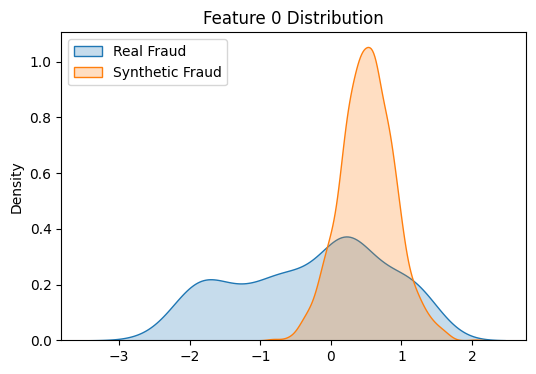

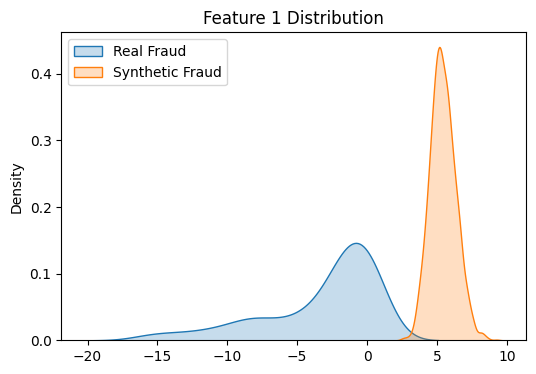

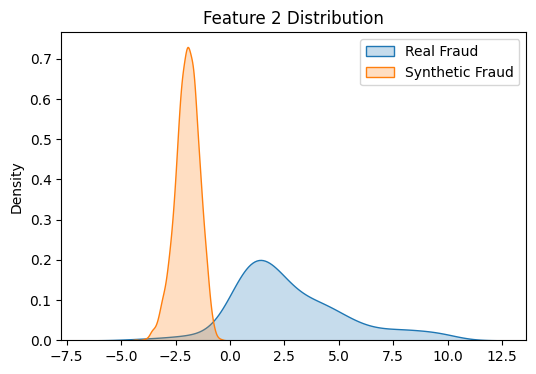

In [ ]:
features_to_plot = [0, 1, 2]  # You can change these indices

for feat in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.kdeplot(fraud_samples[:, feat], label="Real Fraud", fill=True)
    sns.kdeplot(synthetic_data[:, feat], label="Synthetic Fraud", fill=True)
    plt.title(f"Feature {feat} Distribution")
    plt.legend()
    plt.show()


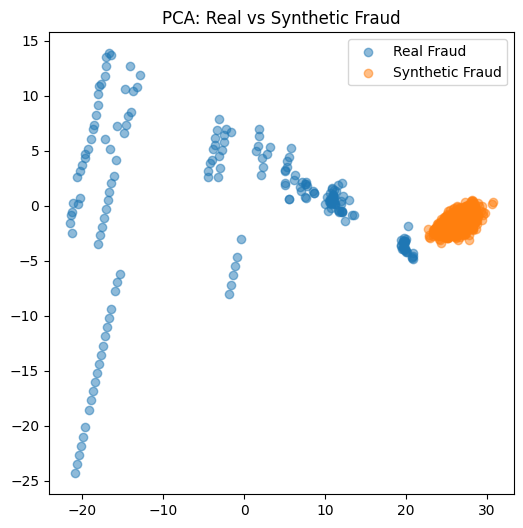

In [ ]:
pca = PCA(n_components=2)
real_pca = pca.fit_transform(fraud_samples)
synthetic_pca = pca.transform(synthetic_data)

plt.figure(figsize=(6,6))
plt.scatter(real_pca[:,0], real_pca[:,1], alpha=0.5, label="Real Fraud")
plt.scatter(synthetic_pca[:,0], synthetic_pca[:,1], alpha=0.5, label="Synthetic Fraud")
plt.title("PCA: Real vs Synthetic Fraud")
plt.legend()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Combine non-fraud, real fraud, and synthetic fraud
X_new = np.vstack([X_scaled[y == 0], fraud_samples, synthetic_data])
y_new = np.hstack([np.zeros(X_scaled[y == 0].shape[0]), np.ones(fraud_samples.shape[0]), np.ones(num_synthetic)])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42, stratify=y_new)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n=== Classification Report on Real + Synthetic Data ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))



=== Classification Report on Real + Synthetic Data ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24924
         1.0       1.00      0.98      0.99       660

    accuracy                           1.00     25584
   macro avg       1.00      0.99      0.99     25584
weighted avg       1.00      1.00      1.00     25584

Accuracy: 0.9994918699186992


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


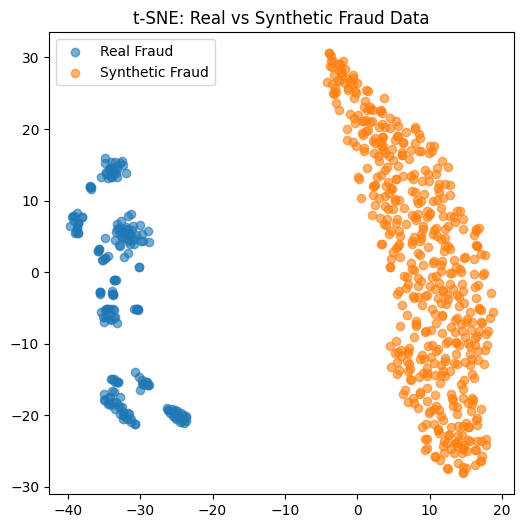

In [ ]:
from sklearn.manifold import TSNE

# Combine a small sample for faster TSNE
real_sample_small = fraud_samples[:500]
synthetic_sample_small = synthetic_data[:500]

combined_data = np.vstack([real_sample_small, synthetic_sample_small])
labels = np.array([0]*len(real_sample_small) + [1]*len(synthetic_sample_small))

# Run TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(combined_data)

# Plot TSNE
plt.figure(figsize=(6,6))
plt.scatter(tsne_results[labels==0, 0], tsne_results[labels==0, 1], alpha=0.6, label="Real Fraud")
plt.scatter(tsne_results[labels==1, 0], tsne_results[labels==1, 1], alpha=0.6, label="Synthetic Fraud")
plt.title("t-SNE: Real vs Synthetic Fraud Data")
plt.legend()
plt.show()


In [ ]:
# Convert synthetic data back to original scale
synthetic_original_scale = scaler.inverse_transform(synthetic_data)

# Create DataFrame
synthetic_df = pd.DataFrame(synthetic_original_scale, columns=df.drop("Class", axis=1).columns)
synthetic_df["Class"] = 1  # Label them as fraud

# Save to CSV
synthetic_df.to_csv("/content/synthetic_fraud_data.csv", index=False)

print("Synthetic fraud data saved as 'synthetic_fraud_data.csv'")


Synthetic fraud data saved as 'synthetic_fraud_data.csv'


In [ ]:
from google.colab import files
files.download("/content/synthetic_fraud_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
synthetic_data = generator.predict(noise)
print("Synthetic dataset size:", synthetic_data.shape)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Synthetic dataset size: (2000, 30)
